In [ ]:
from utils import *
from moves import *

from random_cycles import gen_random_cycles
from local_search import local_search_steepest
from cache import cache_moves_algorithm
from candidate import candidate_moves_algorithm

from MSLS import MSLS
from ILS1 import ILS1
from ILS2 import ILS2, ILS2a

%load_ext autoreload
%autoreload 2

### Extended Local Search

### Run

In [ ]:
times = []
lengths = []
cycles = []

FILENAMES = ['data/kroB200.tsp', 'data/kroA200.tsp']
num_of_runs = 10

for file in FILENAMES:
    data = read_data_file(file)
    distance_matrix = calculate_distance_matrix(data)

    for _ in tqdm(range(num_of_runs)):
        print(f"MSLS")
        cycle1_msls, cycle2_msls, time_elapsed = MSLS(distance_matrix, data, 50)
        msls_length = calculate_cycles_length(cycle1_msls, cycle2_msls, distance_matrix)

        print(f"ILS1")
        start_time = time.time()
        cycle1_ils1, cycle2_ils1 = ILS1(distance_matrix, data, time_elapsed)
        stop_time = time.time()
        time_ILS1 = stop_time - start_time
        ils1_length = calculate_cycles_length(cycle1_ils1, cycle2_ils1, distance_matrix)

        print(f"ILS2")
        start_time = time.time()
        cycle1_ils2, cycle2_ils2 = ILS2(distance_matrix, data, time_elapsed)
        stop_time = time.time()
        time_ILS2 = stop_time - start_time
        ils2_length = calculate_cycles_length(cycle1_ils2, cycle2_ils2, distance_matrix)

        print(f"ILS2a")
        start_time = time.time()
        cycle1_ils2, cycle2_ils2 = ILS2a(distance_matrix, data, time_elapsed)
        stop_time = time.time()
        time_ILS2 = stop_time - start_time
        ils2_length = calculate_cycles_length(cycle1_ils2, cycle2_ils2, distance_matrix)

        times.append((file, "ILS2a", time_ILS2))
        lengths.append((file, "ILS2a", ils2_length))
        cycles.append((file, "ILS2a", cycle1_ils2, cycle2_ils2))

        times.append((file, "MSLS", time_elapsed))
        times.append((file, "ILS1", time_ILS1))
        times.append((file, "ILS2", time_ILS2))
        
        lengths.append((file, "MSLS", msls_length))
        lengths.append((file, "ILS1", ils1_length))
        lengths.append((file, "ILS2", ils2_length))
        
        cycles.append((file, "MSLS", cycle1_msls, cycle2_msls))
        cycles.append((file, "ILS1", cycle1_ils1, cycle2_ils1))
        cycles.append((file, "ILS2", cycle1_ils2, cycle2_ils2))

In [11]:
# Tworzenie DataFrame z czasami
times_df = pd.DataFrame(times, columns=["Instance", "Method", "Time"])
times_df

,Instance,Method,Time
0,data/kroB200.tsp,MSLS,467.529489
1,data/kroB200.tsp,ILS1,477.018051
2,data/kroB200.tsp,ILS2,467.546440
3,data/kroB200.tsp,MSLS,459.854348
4,data/kroB200.tsp,ILS1,469.455335
...,...,...,...
75,data/kroA200.tsp,ILS2a,401.829000
76,data/kroA200.tsp,ILS2a,401.236000
77,data/kroA200.tsp,ILS2a,402.189563
78,data/kroA200.tsp,ILS2a,401.610000


In [12]:
# Tworzenie DataFrame z długościami
lengths_df = pd.DataFrame(lengths, columns=["Instance", "Method", "Length"])
lengths_df

,Instance,Method,Length
0,data/kroB200.tsp,MSLS,34859.235914
1,data/kroB200.tsp,ILS1,36310.329017
2,data/kroB200.tsp,ILS2,35318.361383
3,data/kroB200.tsp,MSLS,36749.276101
4,data/kroB200.tsp,ILS1,35305.112331
...,...,...,...
75,data/kroA200.tsp,ILS2a,32314.450391
76,data/kroA200.tsp,ILS2a,32154.996239
77,data/kroA200.tsp,ILS2a,31287.750689
78,data/kroA200.tsp,ILS2a,33039.638350


In [13]:
# Grupowanie danych i obliczanie statystyk
time_stats = times_df.groupby(["Instance", "Method"])["Time"].agg(['min', 'mean', 'max']).reset_index()
length_stats = lengths_df.groupby(["Instance", "Method"])["Length"].agg(['min', 'mean', 'max']).reset_index()

# Łączenie statystyk w jeden DataFrame
stats_df = pd.merge(time_stats, length_stats, on=["Instance", "Method"], suffixes=("_time", "_length"))
stats_df

,Instance,Method,min_time,mean_time,max_time,min_length,mean_length,max_length
0,data/kroA200.tsp,ILS1,398.439000,401.822894,407.151261,35132.241805,36467.784606,37713.010272
1,data/kroA200.tsp,ILS2,390.630000,393.861476,398.987001,34584.205322,36029.483108,39188.511584
2,data/kroA200.tsp,ILS2a,401.236000,401.775724,402.434999,31287.750689,32032.848833,33039.638350
3,data/kroA200.tsp,MSLS,390.594031,393.835123,398.972001,35405.032448,36231.844409,36537.735383
4,data/kroB200.tsp,ILS1,396.210132,421.961807,477.018051,35305.112331,36128.036000,36766.275195
5,data/kroB200.tsp,ILS2,388.648000,413.776645,467.546440,33276.893733,36248.175578,39280.127460
6,data/kroB200.tsp,ILS2a,401.115705,401.606556,402.008951,32143.933715,32824.243708,34079.993762
7,data/kroB200.tsp,MSLS,388.607016,413.750936,467.529489,34859.235914,36378.274770,37180.009204


In [14]:
cycles_df = pd.DataFrame(cycles, columns=["Instance", "Method", "Cycle1", "Cycle2"])
def calculate_length(row):
    data = read_data_file(row['Instance'])
    distance_matrix = calculate_distance_matrix(data)
    return calculate_cycles_length(row['Cycle1'], row['Cycle2'], distance_matrix)

cycles_df = pd.DataFrame(cycles, columns=["Instance", "Method", "Cycle1", "Cycle2"])
cycles_df['Cycle_Length'] = cycles_df.apply(calculate_length, axis=1)
cycles_df

,Instance,Method,Cycle1,Cycle2,Cycle_Length
0,data/kroB200.tsp,MSLS,"[67, 198, 70, 149, 39, 170, 53, 10, 123, 21, 9...","[133, 66, 145, 199, 131, 178, 94, 180, 157, 17...",34859.235914
1,data/kroB200.tsp,ILS1,"[112, 15, 6, 4, 168, 133, 66, 145, 199, 178, 1...","[73, 85, 122, 93, 11, 3, 158, 28, 129, 91, 97,...",36310.329017
2,data/kroB200.tsp,ILS2,"[144, 160, 162, 135, 130, 44, 148, 102, 200, 1...","[30, 188, 79, 113, 81, 179, 47, 141, 184, 37, ...",35318.361383
3,data/kroB200.tsp,MSLS,"[104, 171, 22, 23, 88, 139, 173, 47, 65, 141, ...","[5, 194, 117, 190, 111, 69, 150, 101, 75, 30, ...",36749.276101
4,data/kroB200.tsp,ILS1,"[136, 29, 123, 10, 68, 190, 117, 40, 39, 149, ...","[79, 188, 65, 141, 184, 37, 72, 169, 115, 191,...",35305.112331
...,...,...,...,...,...
75,data/kroA200.tsp,ILS2a,"[147, 12, 93, 106, 149, 190, 19, 99, 14, 192, ...","[155, 183, 8, 17, 25, 34, 90, 143, 129, 83, 62...",32314.450391
76,data/kroA200.tsp,ILS2a,"[101, 60, 128, 193, 158, 77, 80, 161, 151, 187...","[169, 68, 30, 167, 108, 192, 14, 175, 10, 92, ...",32154.996239
77,data/kroA200.tsp,ILS2a,"[30, 167, 128, 193, 60, 101, 4, 192, 14, 36, 5...","[142, 180, 131, 189, 73, 3, 59, 41, 89, 154, 2...",31287.750689
78,data/kroA200.tsp,ILS2a,"[170, 122, 116, 188, 63, 179, 37, 184, 29, 110...","[199, 26, 61, 136, 32, 24, 159, 111, 85, 145, ...",33039.638350


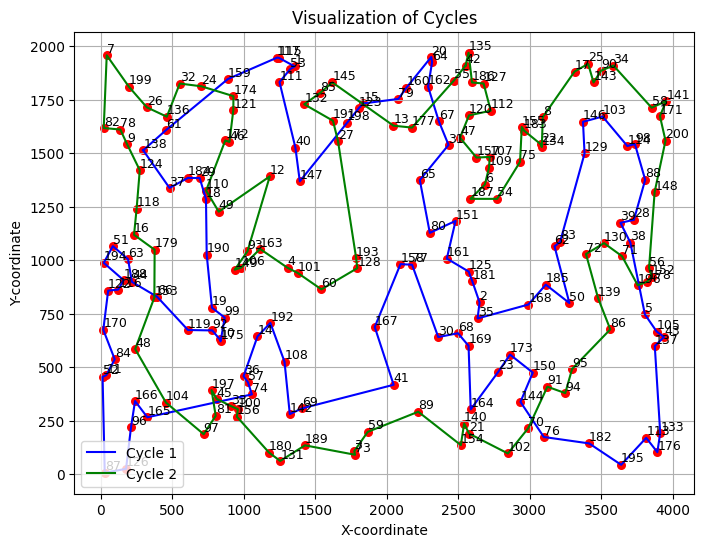

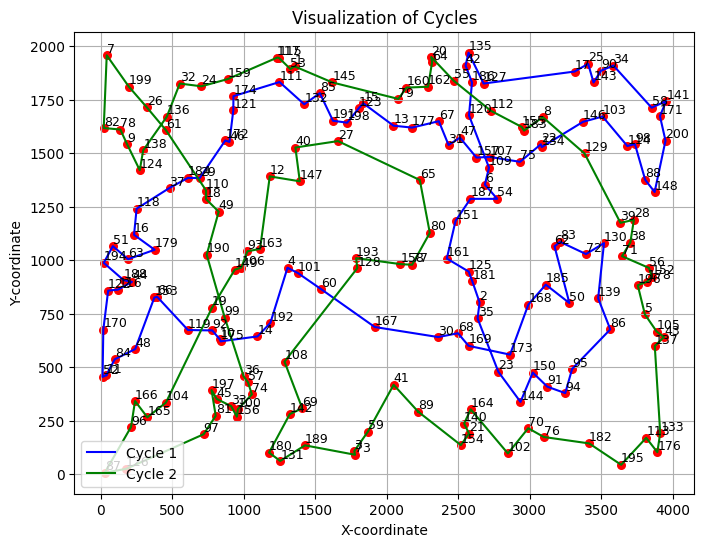

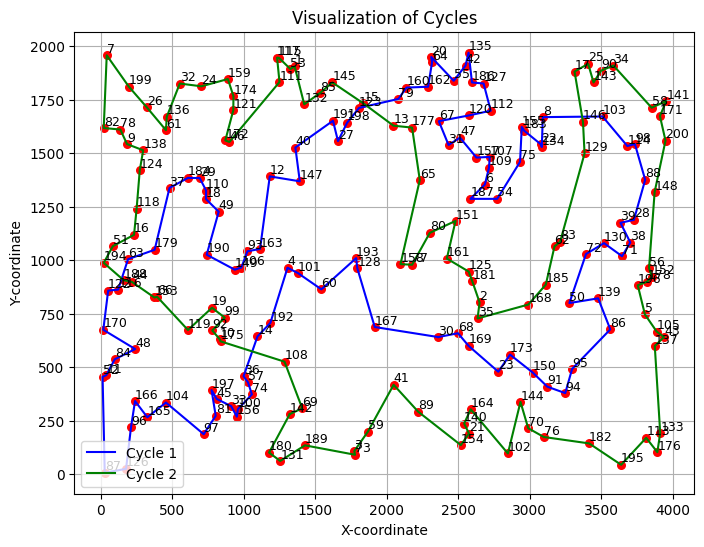

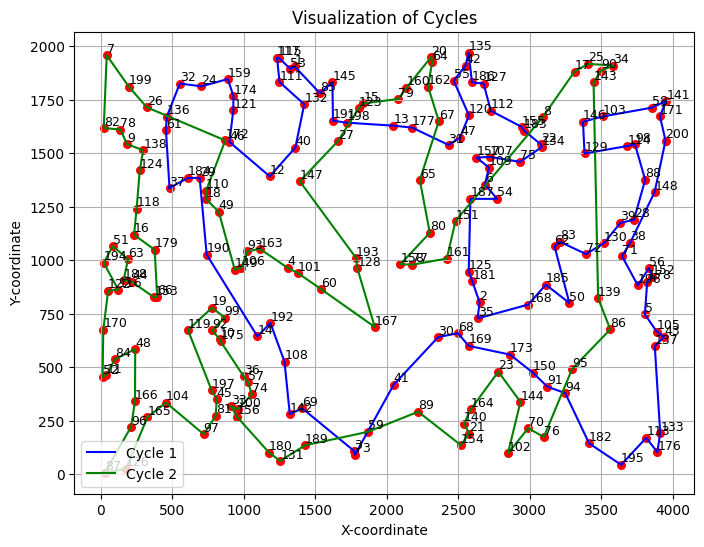

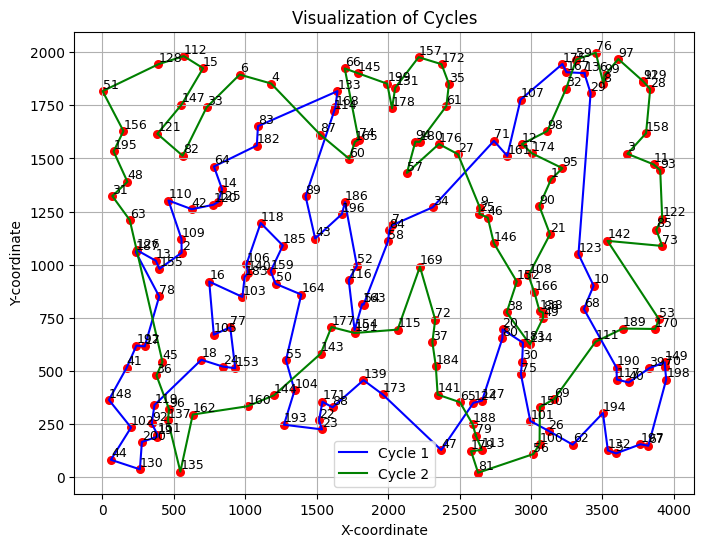

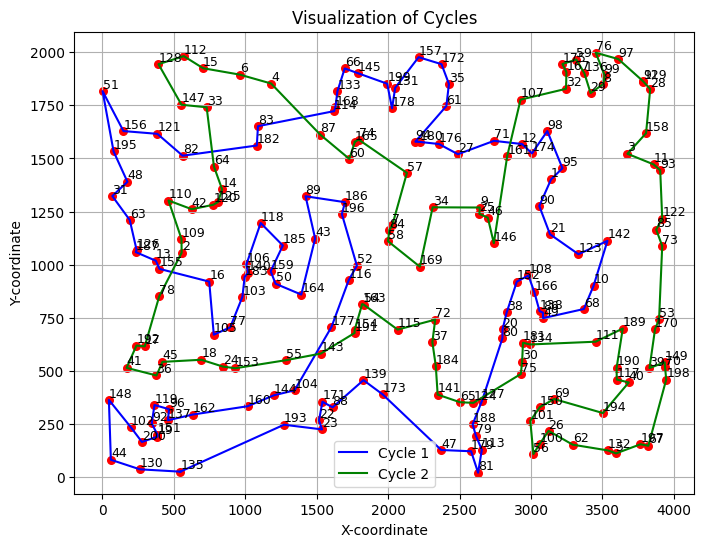

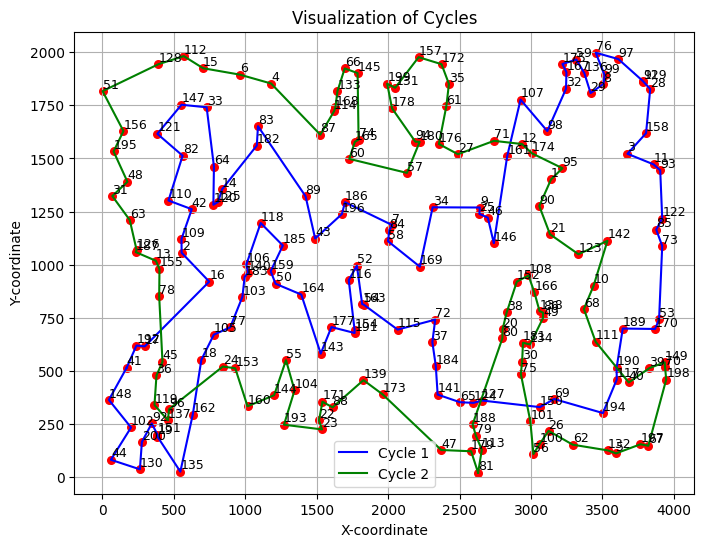

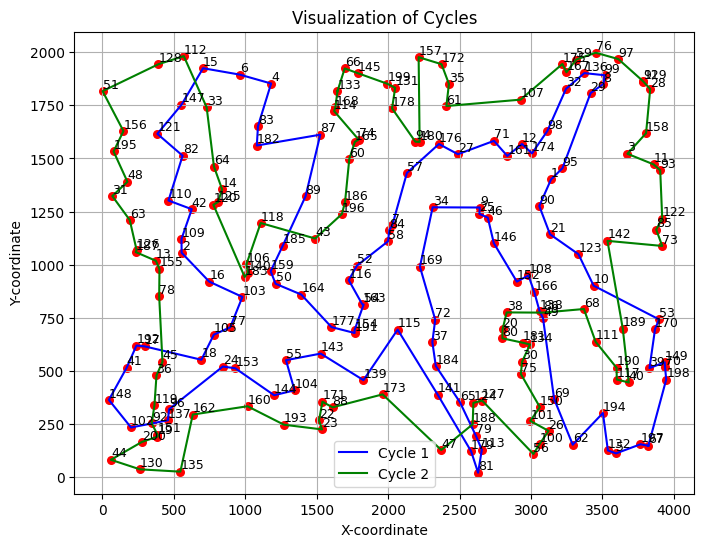

In [18]:
# Group by 'Instance' and 'Method' and find the index of the minimum 'Cycle_Length'
min_cycle_indices = cycles_df.groupby(['Instance', 'Method'])['Cycle_Length'].idxmin()

# Use the indices to get the rows with the minimum 'Cycle_Length'
min_cycles_df = cycles_df.loc[min_cycle_indices]

min_cycles_df

# if dir plots does not exist create it
if not os.path.exists('plots'):
    os.makedirs('plots')

for i, row in min_cycles_df.iterrows():
    plot_cycles(row['Cycle1'], row['Cycle2'], read_data_file(row['Instance']), f"plots/plot_{row['Instance'].replace('/', '')}_{row['Method']}.png")

In [19]:

if not os.path.exists('final_results'):
    os.makedirs('final_results')

# Save the final results
times_df.to_pickle('final_results/times.pkl')
lengths_df.to_pickle('final_results/lengths.pkl')
stats_df.to_pickle('final_results/stats.pkl')
min_cycles_df.to_pickle('final_results/min_cycles.pkl')